In [1]:
from io import BytesIO
import os

import cairo
import IPython.display

from pydmap import natural_lines, hatching

In [2]:
def display_image(render_func, xsize, ysize):
    svgio = BytesIO()
    with cairo.SVGSurface(svgio, xsize, ysize) as surface:
        context = cairo.Context(surface)
        render_func(context, ysize, xsize)
    return svgio

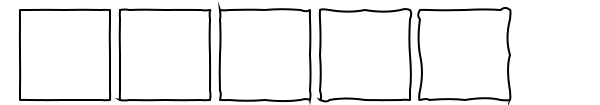

In [3]:
IPython.display.SVG(data=display_image(natural_lines.demo, 600, 105).getvalue())

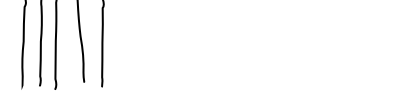

In [4]:
IPython.display.SVG(data=display_image(hatching.demo, 400, 110).getvalue())